# Importing modules

In [1]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_hub as hub
import string
from tensorflow.keras.utils import plot_model

# Getting data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.96 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
#Check all of the files in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

Writing function to visualize our dataset, in this case the dataset are strings

In [6]:
def get_lines(filename):
  '''
  reads filename (a text file) and returns the lines of text as a list

  Args: 
        filename: a string containing the target filepath to read

 Returns:
         A list of strings with one string per line from the target filename
  '''

  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[0:18]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's write a function to give structure to our input data, information about the structure as their explanation can be found in the webpage of the course

In [8]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returns a list of dictionaries from abstract per line

  Takes in filename, reads its content and sorts trhough each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in teh current abstract and what sentence number the 
  target line is

  Args:
        filename: a string of the target text file to read and extract data line
        from

  Returns:
          A list of dictionaries each containing a line from an abstract, the 
          lines label, the lines position in the abstract and the total number 
          of lines in the abstract where the line is from
  '''

  input_lines = get_lines(filename) #get all lines from the filename
  abstract_lines = "" #create an empty abstract
  abstract_samples = [] #create an empty list of abstract

  #Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): #Check if line is an ID line

      abstract_id = line
      abstract_lines = "" #reset abstract string

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() #split abstract into
                            # separate lines
    
      #Iterates through each line in abstract and count them
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty directory to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower it
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) -1 
        abstract_samples.append(line_data)
    
    else:# if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [9]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 606 ms, sys: 95.9 ms, total: 702 ms
Wall time: 725 ms


(180040, 30212, 30135)

In [10]:
train_samples[0:4]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11}]

Truning our list dictionary into a pandas dataframe

In [11]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


**Get lists of sentences**\
our deep learning model will have as inputs a list of strings (each line of an abstract)

In [12]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [13]:
train_sentences

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Making numerical labels from our string labels

In [14]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labe
train_labels_one_hot

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

A different approach to `one hot encoding` is `label encoding` for this case each label is assigned to a different number, e.g, 1, 2,3 

In [15]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [16]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Creating a series of model experiments

## Getting the Baseline

Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

for the label we used the encoded one instead of the one hot encoder because MultinomialNaiveBayes expects 1d array, if we try to use one hot encoder we will have a error message like this:\
`ValueError: y should be a 1d array, got an array of shape (180040, 5) instead`

In [17]:
bayes_model = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("multinomial_bayes", MultinomialNB())
])

#fitting the pipeline to the training data
bayes_model.fit(train_sentences,
                train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()),
                ('multinomial_bayes', MultinomialNB())])

In [18]:
# Evaluate baseline on validation dataset
bayes_model.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

Let's make some predictions with out model

In [19]:
bayes_preds = bayes_model.predict(val_sentences)
bayes_preds

array([4, 1, 3, ..., 4, 4, 1])

# Downloading the helper functions created by the author of the course

In [20]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-02 13:16:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-02 13:16:19 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [21]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [22]:
#calculate baseline results
bayes_results = calculate_results(y_true = val_labels_encoded,
                                  y_pred = bayes_preds)
bayes_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Creating our vectorization (token) and emebedding layers. Vectorization will convert the text to numbers and embedding will obtain the relationship between those numbers

Let's find the average length of our lines

In [23]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [24]:
sent_lens = [len(sentence.split()) for sentence in train_sentences] # it gives me the length of words in each sentence
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [25]:
print('min value: ', np.min(sent_lens))
print('max value: ', np.max(sent_lens))
print('standar deviation: ', np.std(sent_lens))
print('95% of sentences has a length of: ', np.percentile(sent_lens, 95))

min value:  1
max value:  296
standar deviation:  15.38676065622758
95% of sentences has a length of:  55.0


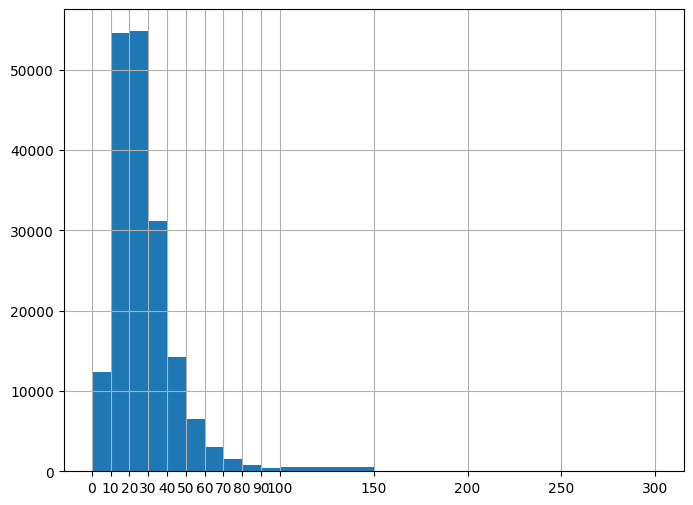

In [26]:
fig, ax = plt.subplots(figsize=[8,6])
ax.hist(sent_lens, bins=[0,10,20,30,40,50,60,70,80,90,100,150,200,250,300])
ax.set_xticks([0,10,20,30,40,50,60,70,80,90,100,150,200,250,300],[0,10,20,30,40,50,60,70,80,90,100,150,200,250,300])
plt.grid();

Sweet!, according to this figure, most of our sentences has a length between 10 and 30 with the mean being 26

**Creating the vectorizer**

According to the authors of the dataset, it has a vocabulary of 68.000, so we will use this as our `max_tokens` parameter

In [27]:
max_tokens = 68000

In [28]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [29]:
text_vectorizer.adapt(train_sentences)

let's try it

In [30]:
text_vectorizer(['this is a random word jejeje'])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[  23,   20,    8,  891, 5236,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [31]:
vocabulary = text_vectorizer.get_vocabulary()
len(vocabulary)

64841

**Creating our embedding (it represents the relationship between the words, now represented in numerical type)**\
Remember that embedding is layer, hence it will be adapted as we train our NN to better represent the relationships

In [32]:
token_embed = layers.Embedding(input_dim=len(vocabulary), #length of our vocabulary
                               output_dim = 128,
                               mask_zero = True,
                               name = 'token_embedding')

# Improving the speed of how our dataset is load to the layers\
`tf.data` API provides methods which enable faster data loading.\
The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets

In [33]:
#Turn our data into TensorFlow dataset

#Notice that in this case we are using OneHotEncodding instead of  encoded
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


Now that we have our data as TensorFlow datasets, we can turn them into **prefetched batches**

In [34]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

Cool! 🐊, now we have our tokenization, embedding, and in addition to that, we have improve the way our data is loaded to the model converting the datasets into tensorflow dataset and then prefetching them.

it is time to start playing aroung with different models, architectures and hyperparameters

# Model 1: CONV1D with token embeddings

All of our deep models will follow a similar structure:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [35]:
# valid_dataset comes from train_labels_one_hot

In this case, I am using **One Hot Encoding**

In [36]:
inputs = layers.Input(shape=(1,), dtype=tf.string) # This layer will accept the words
#each sentence is a vector, that's the reason of our shape
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors) #until this layer, we have been 
#converting words into numbers and obtaining the relationships
# this part is pretty standard and it is about defining the architecture of our NN

x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

#compiling our model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [37]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [38]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 51s 65ms/step - loss: 0.9269 - accuracy: 0.6332 - val_loss: 0.6897 - val_accuracy: 0.7350
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6568 - accuracy: 0.7573 - val_loss: 0.6309 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6156 - accuracy: 0.7751 - val_loss: 0.5971 - val_accuracy: 0.7829


In [39]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5977 - accuracy: 0.7871


[0.5977398753166199, 0.7870713472366333]

In [40]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

945/945 [==============================] - 2s 2ms/step


In [41]:
# Calculate model_1 results
# Notice that I am comparing with the encoded labels instead of the OneHotEncodding
# labels
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.70713623725672,
 'precision': 0.7840503683871317,
 'recall': 0.7870713623725671,
 'f1': 0.7846584176249843}

# Model 2: Feature extraction with pretrained token embeddings

We are going to use the `tensor flow hub` web to donwload a pre-trained NN, in this case the **Universal Sentence Encoder** (USE)

In [42]:
USE_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding_layer = hub.KerasLayer(USE_url,
                                        trainable=False,
                                        name="Universal_Sentence_Encoder")

Building the model, using One hot Encoding 

In [43]:
inputs = layers.Input(shape=[], dtype= tf.string)

pretrained_embedding = tf_hub_embedding_layer(inputs)

x = layers.Dense(64, activation='relu')(pretrained_embedding)

outputs = layers.Dense(len(np.unique(val_labels_encoded)), activation = 'softmax')(x) # we are using the encoded labels 
# instead of the One Hot Encodding labels 

model_USE = tf.keras.Model(inputs, outputs, name = 'USE_encodded')

#compiling the model

model_USE.compile(loss = 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [44]:
model_USE.summary()

Model: "USE_encodded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 Universal_Sentence_Encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


In [45]:
# Fitting our model
model_USE.fit(train_dataset, 
              steps_per_epoch = int(0.1 * len(train_dataset)),
              epochs=3,
              validation_data=valid_dataset,
              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 13ms/step - loss: 0.9589 - accuracy: 0.6368 - val_loss: 0.8088 - val_accuracy: 0.6828
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7809 - accuracy: 0.6941 - val_loss: 0.7690 - val_accuracy: 0.7005
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7664 - accuracy: 0.7065 - val_loss: 0.7586 - val_accuracy: 0.7061


In [46]:
model_USE.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7558 - accuracy: 0.7082


[0.7558127641677856, 0.7082285284996033]

In [47]:
model_USE_pred_probs = model_USE.predict(valid_dataset)
model_USE_preds = tf.argmax(model_USE_pred_probs, axis=1)
model_USE_preds

945/945 [==============================] - 11s 12ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [48]:
model_USE_pred_probs

array([[4.0876272e-01, 3.9501870e-01, 2.2482462e-03, 1.8522467e-01,
        8.7456843e-03],
       [3.3511913e-01, 5.3063738e-01, 3.6212509e-03, 1.2619403e-01,
        4.4281883e-03],
       [1.9136670e-01, 2.2700469e-01, 1.8441129e-02, 5.2037042e-01,
        4.2817075e-02],
       ...,
       [1.8274524e-03, 5.6968038e-03, 5.3529054e-02, 9.3327882e-04,
        9.3801343e-01],
       [4.8668706e-03, 4.4649459e-02, 1.9835606e-01, 2.2088611e-03,
        7.4991876e-01],
       [2.0386101e-01, 1.8587990e-01, 5.1922894e-01, 1.0930255e-02,
        8.0099836e-02]], dtype=float32)

In [49]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_USE_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_USE_preds)
model_USE_results

{'accuracy': 70.82285184694823,
 'precision': 0.7071708885281613,
 'recall': 0.7082285184694823,
 'f1': 0.7042979280136097}

# Model 3: CONV1D with **Character embedding**

Now we are going to use a **character embedding**, which instead of embed each word, each character will be embedded. For example: 

['I like dogs'] --> ['I','','l','i','k','e','','d','o','g','s']

each character will have a numerical representation, it will be turned into a feature vector

['I','','l','i','k','e','','d','o','g','s'] --> [[1232,23213,21321], for 'I'\
..........................................[3213,3213,434], for ''\
..........................................] for 'l'

Let's write a function to split or sentences into characters

In [50]:
def split_chars(text):
  return " ".join(list(text))

let's try it out\
notice that spaces between words are counted as characters and it will add an additional space

In [51]:
" ".join(list('ab asd'))

'a b   a s d'

Let's create a character-level dataset by splitting our sequence datasets into characters

In [52]:
train_sentences[0:2]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .']

In [53]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [54]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

Now, each sentence is split it into their characters and I can access to each character

To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths

In [55]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

`char_lens` contains the lenght of characters for each sentence

In [56]:
char_lens[0:3]

[281, 137, 111]

In [57]:
np.percentile(char_lens,95)

290.0

Now, let's make the vectorization of each character (tokenization)

the maximum number of tokens will be the extension of different characters in the alphabet (a-z) plus numbers and unknown characters

the maximum output length will be 290, the 95 of our charachter lenght in sentences. A lower number could do that many sentencens will be crut out and not all characters will be represented. A longer extension will be inefficient our model

In [58]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [59]:
len(alphabet)

68

In [60]:
#creating our vectorization
NUM_CHAR_TOKENS = len(alphabet) + 2 # to take into consideration unknown characters
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = 290,
                                    standardize = 'lower_and_strip_punctuation',
                                    name= 'char_vectorizer')

char_vectorizer.adapt(train_chars)

In [61]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()

Also, due to the standardize parameter of TextVectorization being "lower_and_strip_punctuation" and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed

**Creating our embedding**


The input dimension will be the number of different characters in our vectorization, in this case 75, and since we are following the paper, the output will be 25

In [62]:
NUM_CHAR_TOKENS

70

In [63]:
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                              output_dim = 25,
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name='char_embed')

Great 🐊: we have our character embedding and we can continue with the standar procedure, creating the NN

# Building a Conv1D model to fit on character embeddings

The model will have the same structure as our custom token embedding model (model_1) except it'll take character-level sequences as input instead of token-level sequences.

In [64]:
inputs = layers.Input(shape=(1,), dtype='string')

char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)

x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embedding)
x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(5,activation='softmax')(x)

model_3_char = tf.keras.Model(inputs, outputs, name='character_embedding')

#compiling model
model_3_char.compile(loss='categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [65]:
model_3_char.summary()

Model: "character_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)         

Creating train and test char dataset in the tensorflow way to optimize the training

In [66]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [67]:
# Fit the model on chars only
model_3_history = model_3_char.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2732 - accuracy: 0.4912 - val_loss: 1.0453 - val_accuracy: 0.5838
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0011 - accuracy: 0.5949 - val_loss: 0.9382 - val_accuracy: 0.6290
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9337 - accuracy: 0.6317 - val_loss: 0.8721 - val_accuracy: 0.6616


In [68]:
# Make predictions with character model only
model_3_pred_probs = model_3_char.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.24424902, 0.36170125, 0.10928132, 0.22012255, 0.06464592],
       [0.140196  , 0.7075376 , 0.01117859, 0.12412455, 0.01696332],
       [0.1269057 , 0.2613292 , 0.28276083, 0.1331936 , 0.19581066],
       ...,
       [0.05083617, 0.05196426, 0.13342619, 0.03757558, 0.7261978 ],
       [0.04878584, 0.09243334, 0.5787034 , 0.03957282, 0.24050453],
       [0.38072923, 0.39791965, 0.17642088, 0.03368546, 0.01124469]],
      dtype=float32)

In [69]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 64.99404210247583,
 'precision': 0.641715794155464,
 'recall': 0.6499404210247584,
 'f1': 0.6364565790263911}

WoW!, it seems like our approach of character embedding gave worst results than word embedding

# Model 4: Combining pretrained model embedding + character embeddings (hybrid embedding layer)

We are going to combine the token embedding (words) and the character embedding (characters) into a single NN./
Let's see how to do it

We are going through the following steps:

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3)
3. Combine(using `layers.concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output 

Alll righttt 🧑 so let's see how to do it

In [70]:
#1. setup token inputs/model
token_inputs = layers.Input(shape=[], dtype= tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2. setup character input/model
character_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(character_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embedding) #to recreate the architecture of the paper
char_model = tf.keras.Model(character_inputs,char_bi_lstm)

#3. concatenate token and character inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,char_model.output ])
#notice the ".output" at the end of the model when I concatenate them 

#4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation='softmax')(final_dropout)

#5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [71]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 Universal_Sentence_Encoder (Ke  (None, 512)         256797824   [

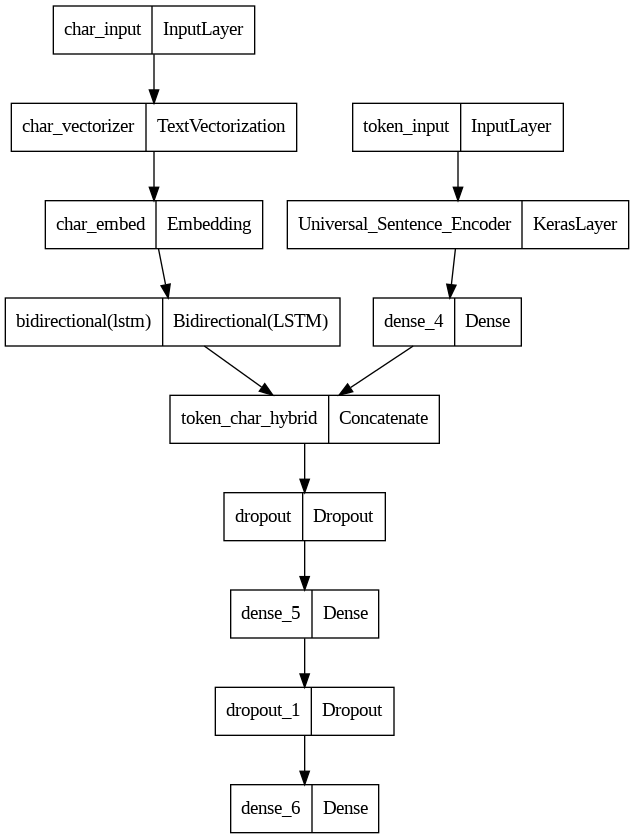

In [72]:
plot_model(model_4)

Let's compile our model, in this case instead of using Adam will be use StochasticGradientDescent (SGD) as our optimizer

In [73]:
model_4.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In this case our model requires two inputs, one is the token (sentences with words) and the other the characters (sentences split into characters)


In [74]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #notice that in this ocassion I gave as input
# a tuple because we need two inputs
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

#additionally, we can combine our train and  label data into one
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [75]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

**Fitting our model**

With **SGD**

In [76]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 36ms/step - loss: 0.9741 - accuracy: 0.6102 - val_loss: 0.7851 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 22s 38ms/step - loss: 0.7909 - accuracy: 0.6953 - val_loss: 0.7141 - val_accuracy: 0.7317
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7614 - accuracy: 0.7109 - val_loss: 0.6842 - val_accuracy: 0.7410


In [77]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results


945/945 [==============================] - 18s 18ms/step


{'accuracy': 73.68595260161526,
 'precision': 0.7369909335046536,
 'recall': 0.7368595260161526,
 'f1': 0.7348206812599275}

The perfomance is really bad, recall we used SGD, let's try the same but using Adam and see the difference

with **Adam**

In [78]:
model_4_history_adam = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7363 - accuracy: 0.7206 - val_loss: 0.6665 - val_accuracy: 0.7487
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7101 - accuracy: 0.7302 - val_loss: 0.6517 - val_accuracy: 0.7550
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7075 - accuracy: 0.7290 - val_loss: 0.6407 - val_accuracy: 0.7530


In [79]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results


945/945 [==============================] - 17s 18ms/step


{'accuracy': 75.34754402224281,
 'precision': 0.7520206074572703,
 'recall': 0.7534754402224282,
 'f1': 0.7511954922227226}

WoW!, only changing the optimizer the results chaged a lot!! 🤯

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In this ocassion we are going to add an additional step:

we are going to engineered our own feature into the model 

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called **feature engineering**.

The idea of what we are going to do is explained in more detail in the web page. But the main idea is that each label of the abstract,i.e., background, objectives, methods, results, and conclusions occupy a position within the whole abstract.
We expect to obser eiteher backgrong or objective in the first sentences and conclusions in the last. So we can convert this information into numbers to help our model to achieve better results.

For example if one random abstract has 30 sentences we can say that 1/30 is for backgroud, 2/30,3/30 for goals, 4/30 to 14/30 to methods and go on...

In [80]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


Notice that **line_number** and **total_lines** are not in the original dataset but we make it to obtain extra information. We **feature engineered** those

Creating positional embeddings

Since **line_number** and **total_lines** are already in numeric format, we can pass them as they are to our model

But to avoid our model thinking a line with "line_number"=5 is five times greater than a line with "line_number"=1, we'll use one-hot-encoding to encode our "line_number" and "total_lines" features

tf.one_hot returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the depth parameter determines the dimension of the returned tensor.

To figure out what we should set the depth parameter to, let's investigate the distribution of the "line_number" column.

In [81]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

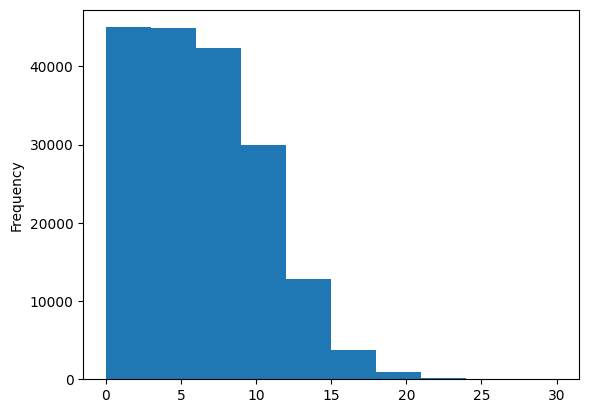

In [82]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the depth parameter of tf.one_hot to 15

In [83]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=16)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=16)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=16)

In [84]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

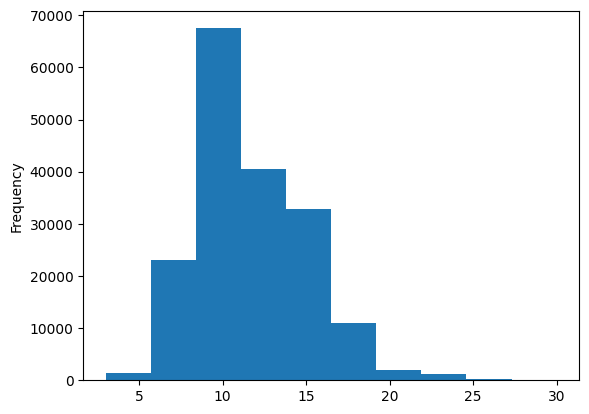

In [85]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [86]:
np.percentile(train_df["total_lines"], 98)

20.0

In [87]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

**Let's build the model**

In [88]:
#1. token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2. char inputs
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#3. Line number inputs
line_number_inputs = layers.Input(shape=(16,), dtype=tf.int32, name='line_number_inputs')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

#4. total line inputs
total_line_inputs = layers.Input(shape=(20,), dtype=tf.int32, name='total_line_input')
y = layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs,
                                  outputs=y)

#5. combine token and char embedding into a hybrid embedding 
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

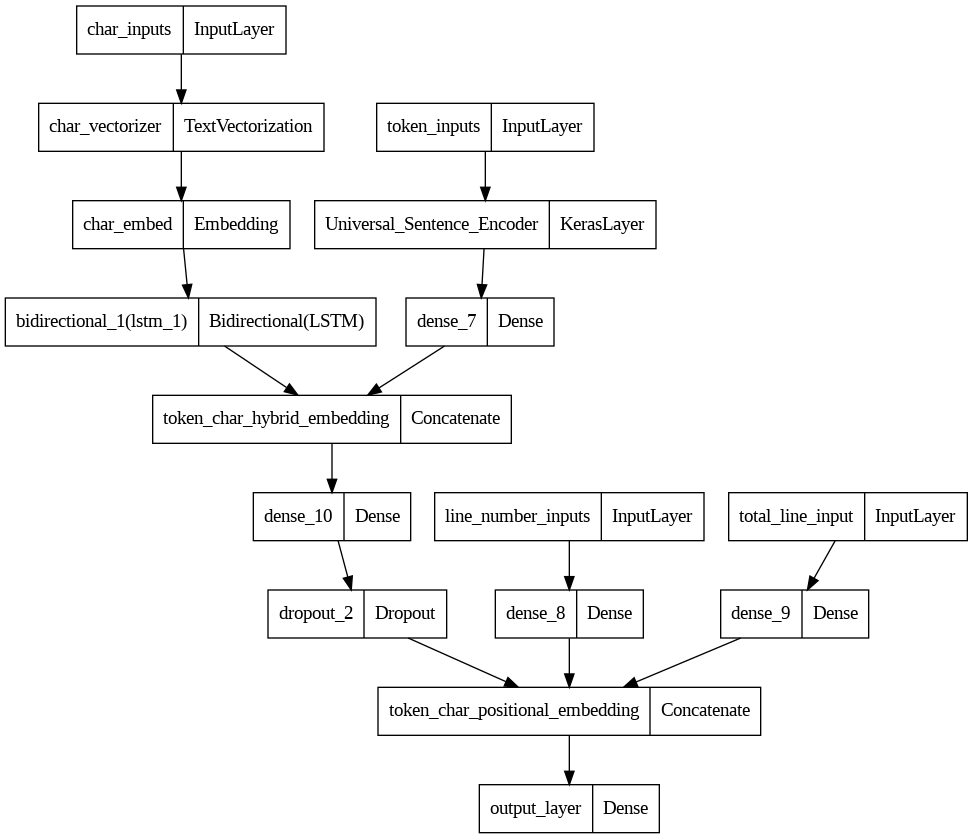

In [89]:
plot_model(model_5)

In [90]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Creating the input in the format requiered for our model

In [91]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [92]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 35s 46ms/step - loss: 1.0892 - accuracy: 0.7311 - val_loss: 0.9830 - val_accuracy: 0.8012
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9654 - accuracy: 0.8173 - val_loss: 0.9501 - val_accuracy: 0.8311
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.9494 - accuracy: 0.8243 - val_loss: 0.9376 - val_accuracy: 0.8328


In [93]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

945/945 [==============================] - 27s 28ms/step


{'accuracy': 83.47676419965576,
 'precision': 0.8339348569732521,
 'recall': 0.8347676419965576,
 'f1': 0.8337087139093542}

# Compare model results

In [94]:
all_model_results = pd.DataFrame({'bayes': bayes_results,
                                  'CONV1D' : model_1_results,
                                  "model_USE_results": model_USE_results,
                                  "model_charac_emb":model_3_results,
                                  "model_token_char":model_4_results,
                                  "model_token_emb_featurevector":model_5_results})

In [101]:
all_model_results=all_model_results.T

In [108]:
all_model_results

,accuracy,precision,recall,f1
bayes,0.721832,0.718647,0.721832,0.698925
CONV1D,0.787071,0.784050,0.787071,0.784658
model_USE_results,0.708229,0.707171,0.708229,0.704298
model_charac_emb,0.649940,0.641716,0.649940,0.636457
model_token_char,0.753475,0.752021,0.753475,0.751195
model_token_emb_featurevector,0.834768,0.833935,0.834768,0.833709


In [102]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

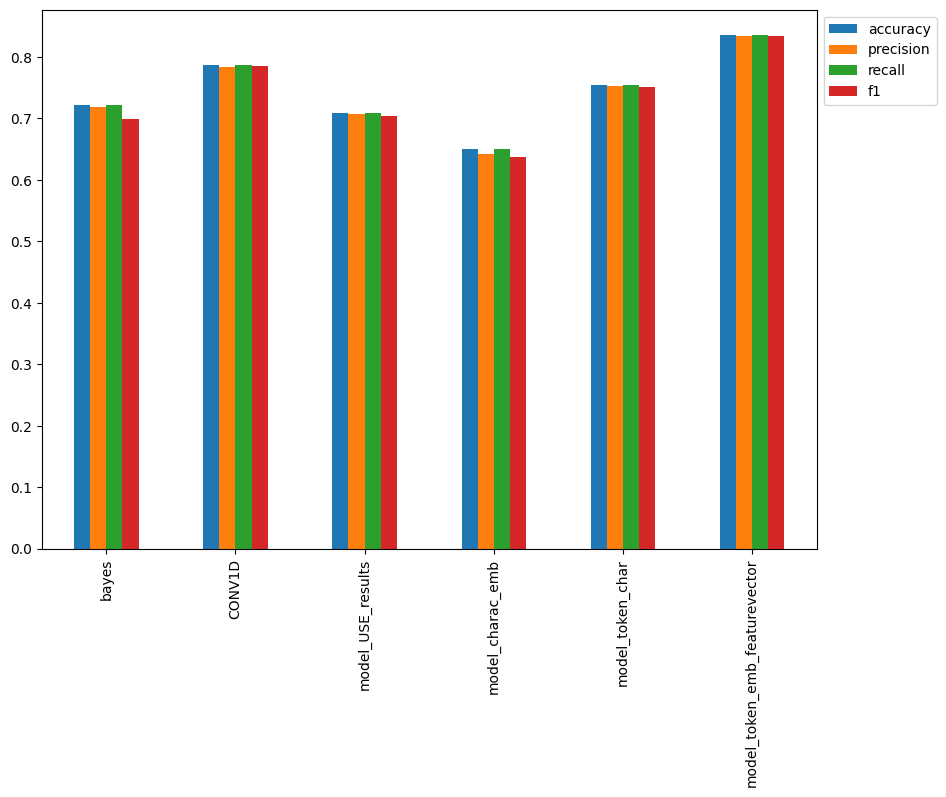

In [103]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


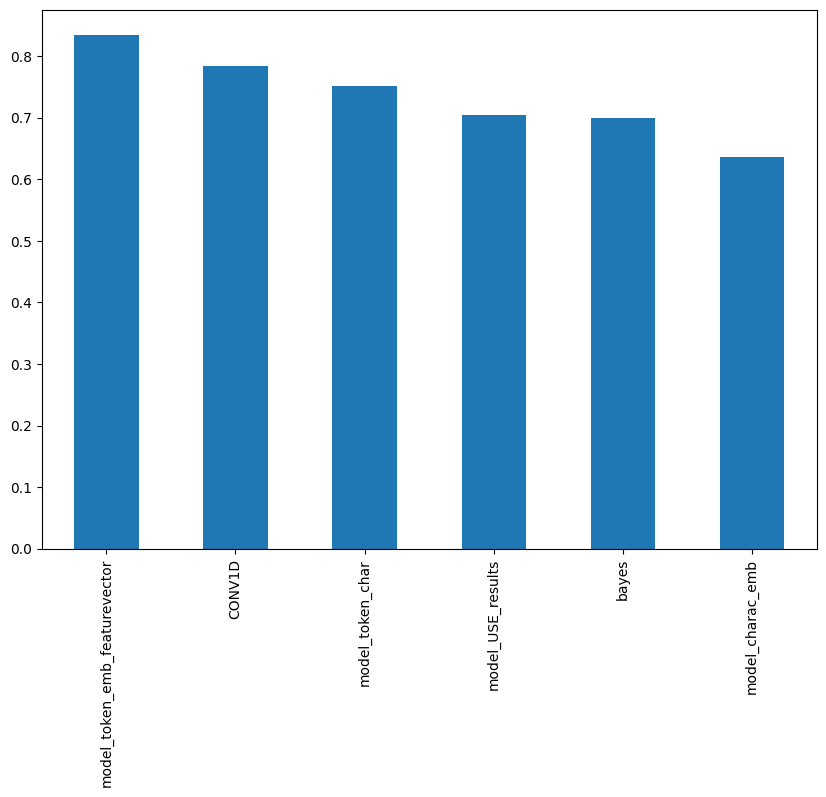

In [104]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));


# Save and load best performing model

In [123]:
model_5.save("skimlit_tribrid_model")

Loading the model

since it uses a couple of custom objects (our TensorFlow Hub layer and TextVectorization layer), we'll have to load it in by specifying them in the custom_objects parameter of tf.keras.models.load_model()

In [129]:
!ls

helper_functions.py  pubmed-rct   sample_data
model.png	     __pycache__  skimlit_tribrid_model


In [130]:
model_path = "skimlit_tribrid_model"

loaded_model = tf.keras.models.load_model(model_path),
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file 
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding

In [135]:
loaded_model[0].layers

In [138]:
loaded_model[1]

IndexError: ignored


Make predictions and evalaute them against the truth labels

To make sure our model saved and loaded correctly, let's make predictions with it, evaluate them and then compare them to the prediction results we calculated earlier.\

In [136]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model[0].predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)

loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

945/945 [==============================] - 21s 21ms/step


{'accuracy': 83.47676419965576,
 'precision': 0.8339348569732521,
 'recall': 0.8347676419965576,
 'f1': 0.8337087139093542}

**It's worth noting that loading in a SavedModel unfreezes all layers (makes them all trainable). So if you want to freeze any layers, you'll have to set their trainable attribute to False.**

In [140]:
loaded_model[0].summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 Universal_Sentence_Encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

# Test model on the Test dataset

Let's make some prediction on the test dataset (so far we have been using only the train and validation dataset)

In [141]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [143]:
# Make predictions on the test dataset
test_pred_probs = loaded_model[0].predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)

# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

942/942 [==============================] - 17s 18ms/step


{'accuracy': 82.95669487307119,
 'precision': 0.8281936496477689,
 'recall': 0.8295669487307118,
 'f1': 0.8284065953610087}

## Find the **most wrong predictions**

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

First we'll convert all of our integer-based test predictions into their string-based class names.



In [146]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[0:5]

['OBJECTIVE', 'BACKGROUND', 'METHODS', 'METHODS', 'RESULTS']

Now we'll enrich our test DataFame with a few values:

* "prediction" (string) column containing our model's prediction for a given sample.

* "pred_prob" (float) column containing the model's maximum prediction probabiliy for a given sample.

* "correct" (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [147]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.471404,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.334956,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.791748,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.632835,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.694426,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.866689,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.538912,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.509885,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.452331,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.562154,True


Let's sort our DataFrame to find the samples with the highest "pred_prob" and where the prediction was wrong ("correct" == False)?

In [150]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values(by=['pred_prob'], ascending = False)[:100]
top_100_wrong 

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.947551,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.935702,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.933594,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.926057,False
16580,OBJECTIVE,"second , we collected patient-reported outcome...",4,27,METHODS,0.920636,False
...,...,...,...,...,...,...,...
2219,CONCLUSIONS,among men and women with moderately elevated b...,7,8,RESULTS,0.837726,False
12304,BACKGROUND,"the severity of psychiatric symptoms , as meas...",2,16,METHODS,0.837486,False
11995,RESULTS,the primary endpoint was a combined endpoint o...,5,13,METHODS,0.836187,False
27935,RESULTS,health status was measured by generic ( short ...,4,8,METHODS,0.835534,False


# Using our model to make prediction of real abstracts

In [151]:
import json

In [152]:
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-04-02 15:38:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-04-02 15:38:50 (61.5 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [153]:
len(example_abstracts)

4

In [154]:
example_abstracts[0]

{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
 'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
 'details': 'RCT of a manualized 

Now that we have our abstracts, we need to give it the rigth shape for being used in por model:

1. separate the abstract into different sentences.
2. Count the line and the total number of lines\
  2.1 one hot encoded total_lines and line_number 

For separate the abstract into lines we are going to use **spacy**

In [156]:
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object
#nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [157]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

One hot encoding total_lines and line_number

In [158]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]


In [159]:
test_abstract_line_numbers

[0, 1, 2, 3, 4, 5, 6, 7]

In [166]:
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=16) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 16), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [161]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

Splitting our abstract lines into characters

In [163]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

Niceeee 🐊. Now we have the inputs in our required format. It is time to make some predictions!

In [167]:
%%time
test_abstract_pred_probs = loaded_model[0].predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 1s/step
CPU times: user 1.13 s, sys: 15.6 ms, total: 1.15 s
Wall time: 1.11 s


array([[0.28419164, 0.10326672, 0.01409838, 0.5768793 , 0.02156395],
       [0.06517401, 0.03594554, 0.71192706, 0.09627335, 0.09068005],
       [0.12848775, 0.06329222, 0.4986157 , 0.20409966, 0.10550463],
       [0.12032963, 0.18778974, 0.4492057 , 0.09025902, 0.15241592],
       [0.054285  , 0.09458316, 0.39010993, 0.05134421, 0.40967774],
       [0.03309223, 0.09729416, 0.6144697 , 0.04239132, 0.21275252],
       [0.03301806, 0.18807991, 0.09128705, 0.02863035, 0.6589846 ],
       [0.01667566, 0.14571345, 0.29526713, 0.0333437 , 0.50900006]],
      dtype=float32)

In [168]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [169]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
